In [ ]:
import os
import sys
import uuid
import shutil
from collections import Counter, OrderedDict

import kagglehub

from xml.etree import ElementTree as ET

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

import torchvision
from torchvision import transforms
from torchvision.transforms import functional as T

from torchvision.ops import box_iou

from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

from torchvision.models.detection import retinanet_resnet50_fpn, RetinaNet_ResNet50_FPN_Weights
from torchvision.models.detection.retinanet import RetinaNetClassificationHead

# from torchmetrics.detection.mean_ap import MeanAveragePrecision

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import cv2

import PIL

from tqdm.auto import tqdm

In [ ]:
import google

google.colab.drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
device = torch.device(
  "cuda" if torch.cuda.is_available() else
  "mps" if torch.backends.mps.is_available() else
  "cpu")
device

device(type='cpu')

In [ ]:
classes = {
  1: "Gomphonema olivaceum",
  2: "Navicula cryptotenella",
  3: "Fragilaria recapitellata",
  4: "Encyonema silesiacum",
  5: "Navicula reichardtiana",
  6: "Planothidium lanceolatum",
  7: "Gomphonema tergestinum",
  8: "Navicula cryptotenelloides",
  9: "Rhoicosphenia abbreviata",
  10: "Meridion circulare",
  11: "Surirella brebissonii var. kuetzingii",
  12: "Encyonema ventricosum",
  13: "Achnanthidium biasolettianum",
  14: "Cymbella excisa",
  15: "Diatoma moniliformis",
  16: "Cymbella cantonatii",
  17: "Diatoma mesodon",
  18: "Humidophila contenta",
  19: "Cocconeis pseudolineata",
  20: "Navicula upsaliensis",
  21: "Cymbella excisa var. subcapitata",
  22: "Halamphora veneta",
  23: "Gomphonema calcifugum",
  24: "Nitzschia linearis",
  25: "Pinnularia brebissonii",
  26: "Humidophila perpusilla",
  27: "Navicula trivialis",
  28: "Gomphonema pumilum var. rigidum",
  29: "Halamphora paraveneta",
  30: "Nitzschia hantzschiana",
  31: "Pantocsekiella ocellata",
  32: "Planothidium frequentissimum",
  33: "Adlafia minuscula",
  34: "Navicula cryptocephala",
  35: "Amphora pediculus",
  36: "Navicula tripunctata",
  37: "Navicula gregaria",
  38: "Nitzschia archibaldii",
  39: "Navicula moskalii",
  40: "Epithemia argus",
  41: "Gomphonema micropus",
  42: "Gomphonema minutum",
  43: "Navicula capitatoradiata",
  44: "Gomphonema drutelingense",
  45: "Denticula kuetzingii",
  46: "Gomphonema supertergestinum",
  47: "Achnanthidium minutissimum",
  48: "Frustulia vulgaris",
  49: "Gomphonema pumilum",
  50: "Hantzschiana abundans",
  51: "Caloneis lancettula",
  52: "Navicula novaesiberica",
  53: "Sellaphora radiosa",
  54: "Navicula lanceolata",
  55: "Gomphonema exilissimum",
  56: "Diploneis fontanella",
  57: "Luticola nivalis",
  58: "Epithemia goeppertiana",
  59: "Nitzschia recta",
  60: "Stauroneis blazenciciae",
  61: "Cymbopleura amphicephala",
  62: "Cymbella excisa var. procera",
  63: "Nitzschia palea",
  64: "Didymosphenia geminata",
  65: "Sellaphora saugerresii",
  66: "Amphora inariensis",
  67: "Neidiomorpha binodiformis",
  68: "Surella minuta"
}

class_to_idx = {v: k for k, v in classes.items()}

banned_xml_files = [
  "388.xml",
  "1147.xml",
  "366.xml",
  "1418.xml",
  "488.xml",
  "1256.xml",
  "475.xml",
  "1067.xml",
  "1310.xml",
  "453.xml",
  "284.xml",
  "233.xml",
  "437.xml",
]

def parse_xml(filepath):
  tree = ET.parse(filepath)
  root = tree.getroot()

  filename = root.find("filename").text + ".png"

  objs = []

  for obj in root.findall("objects/object"):
    class_name = obj.find("name").text

    xmin = int(obj.find("bbox/xmin").text)
    xmax = int(obj.find("bbox/xmax").text)
    ymin = int(obj.find("bbox/ymin").text)
    ymax = int(obj.find("bbox/ymax").text)

    objs.append({
      "class_name": class_name,
      "xmin": xmin,
      "xmax": xmax,
      "ymin": ymin,
      "ymax": ymax,
    })

  return {
    "filename": filename,
    "objects": objs
  }

class DiatomDataset(Dataset):
  def __init__(self, root_dir, classes, class_to_idx, banned_xml_files=[], transform=None, train=True):
    self.root_dir = root_dir
    self.classes = classes
    self.class_to_idx = class_to_idx
    self.transform = transform

    self.xml_dir = os.path.join(self.root_dir, "xmls")
    self.image_dir = os.path.join(self.root_dir, "images")

    self.xml_files = os.listdir(self.xml_dir)
    self.xml_files = [
      xml_file for xml_file in self.xml_files if xml_file.endswith(".xml") and xml_file not in banned_xml_files
    ]

    split_idx = int(len(self.xml_files) * 0.8)

    if train:
      self.xml_files = self.xml_files[:split_idx]
    else:
      self.xml_files = self.xml_files[split_idx:]

  def __len__(self):
    return len(self.xml_files)

  def __getitem__(self, index):
    xml = parse_xml(os.path.join(self.xml_dir, self.xml_files[index]))

    image_filename = os.path.join(self.image_dir, xml["filename"])

    image = PIL.Image.open(image_filename).convert("RGB")
    if self.transform:
      image = self.transform(image)

    boxes, labels = zip(*[
      (
        (*self._extract_bndbox(obj),), self.class_to_idx[obj["class_name"]]
      ) for obj in xml["objects"]
    ])

    target = {
      "boxes": torch.tensor(boxes, dtype=torch.float32),
      "labels": torch.tensor(labels, dtype=torch.int64),
      "filename": xml["filename"],
    }

    return image, target

  def _extract_bndbox(self, obj):
    return obj["xmin"], obj["ymin"], obj["xmax"], obj["ymax"]

def get_diatom_dataset(root_dir):
  train_dataset = DiatomDataset(
    root_dir,
    classes,
    class_to_idx,
    banned_xml_files,
    transform=transforms.ToTensor(),
    train=True
  )

  val_dataset = DiatomDataset(
    root_dir,
    classes,
    class_to_idx,
    banned_xml_files,
    transform=transforms.ToTensor(),
    train=False
  )

  return train_dataset, val_dataset

def get_diatom_dataloader(train_dataset, val_dataset, batch_size, num_workers, prefetch_factor):
  train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=prefetch_factor,
    persistent_workers = True if num_workers > 0 else False,
    collate_fn=lambda batch: tuple(zip(*batch))
  )

  val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=prefetch_factor,
    persistent_workers = True if num_workers > 0 else False,
    collate_fn=lambda batch: tuple(zip(*batch))
  )

  return train_dataloader, val_dataloader

In [ ]:
diatom_dataset_root_dir = kagglehub.dataset_download("huseyingunduz/diatom-dataset")

train_dataset, val_dataset = get_diatom_dataset(diatom_dataset_root_dir)

train_dataloader = DataLoader(
  dataset=train_dataset,
  batch_size=2,
  shuffle=True,
  num_workers=1,
  pin_memory=True,
  prefetch_factor=2,
  persistent_workers=True,
  collate_fn=lambda batch: tuple(zip(*batch))
)

val_dataloader = DataLoader(
  dataset=val_dataset,
  batch_size=2,
  shuffle=False,
  num_workers=1,
  pin_memory=True,
  prefetch_factor=2,
  persistent_workers=True,
  collate_fn=lambda batch: tuple(zip(*batch))
)

100%|██████████| 8.71G/8.71G [01:32<00:00, 101MB/s]

Extracting files...


In [ ]:
def count_class(dataset):
  all_labels = []
  for imgs, targets in dataset:
    all_labels.extend(targets["labels"].tolist())
  return all_labels

val_class_count = count_class(val_dataset)

In [ ]:
val_class_count_list = [0] * len(classes)
for label in val_class_count:
  val_class_count_list[label-1] += 1

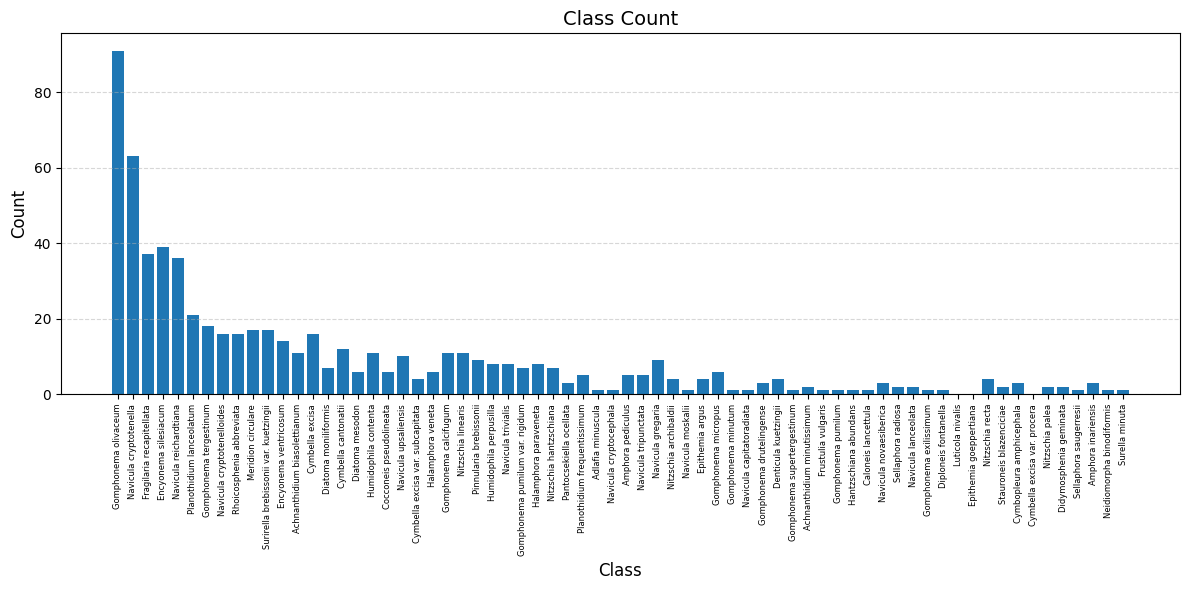

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(classes.keys(), val_class_count_list)

plt.title("Class Count", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.5)

xticks = list(classes.keys())
xtick_labels = [classes[x] for x in xticks]

plt.xticks(xticks, xtick_labels, rotation=90, fontsize=6)

plt.tight_layout()
plt.show()

In [ ]:
torch.save(val_class_count_list, "val_class_list.pt")

In [ ]:
for i, count in enumerate(val_class_count_list):
  print(f"{i+1:2}:{classes[i+1]:40}: {count}")

 1:Gomphonema olivaceum                    : 91
 2:Navicula cryptotenella                  : 63
 3:Fragilaria recapitellata                : 37
 4:Encyonema silesiacum                    : 39
 5:Navicula reichardtiana                  : 36
 6:Planothidium lanceolatum                : 21
 7:Gomphonema tergestinum                  : 18
 8:Navicula cryptotenelloides              : 16
 9:Rhoicosphenia abbreviata                : 16
10:Meridion circulare                      : 17
11:Surirella brebissonii var. kuetzingii   : 17
12:Encyonema ventricosum                   : 14
13:Achnanthidium biasolettianum            : 11
14:Cymbella excisa                         : 16
15:Diatoma moniliformis                    : 7
16:Cymbella cantonatii                     : 12
17:Diatoma mesodon                         : 6
18:Humidophila contenta                    : 11
19:Cocconeis pseudolineata                 : 6
20:Navicula upsaliensis                    : 10
21:Cymbella excisa var. subcapitata        